# AC simulation of asymmetric single carrier devices

This shows calculation of simulated capacitance-voltage (C-V) curves using AC analysis functionality. 

It reproduces previously published [reference](https://doi.org/10.1103/PhysRevLett.100.086802), on the determination of injection barriers from C-V measurements.

## Simulation setup

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import oedes
import numpy as np
import scipy.constants # for epsilon_0
oedes.init_notebook()

### Common parameters:

Common physical parameters are stored in `params`. Additionally, device thickness `L`, frequency `freq`, and  list of voltage points in `voltages` must be defined.

In [2]:
params = {
    'T': 300., # K
    'electrode0.voltage': 0., # V
    'electrode0.workfunction': 0., # eV
    'electrode1.voltage': 0., # V
    'electrode1.workfunction': 0., # eV
    'hole.N0': 1e27, # 1/m3
    'hole.energy': 0., # eV
    'hole.mu': 1e-9, # m2/(Vs)
    'epsilon_r': 3. # 1
}
L = 100e-9 # sample thickness, m
Cgeom = params['epsilon_r'] * scipy.constants.epsilon_0 / L # F/m2
voltages = np.linspace(-1, 2, 200) # V
freq = 1e3 # Hz

### Device model

Standard single layer, hole-only device model is used in this example:

In [3]:
device_model = oedes.models.holeonly(L)

### Convenience function C-V simulation

AC analysis returns AC current $ \tilde{J} $ calculated for unit AC excitation $ \tilde{V} $. Capacitance is extracted assuming that entire imaginary part of current is capacitive, $ \Im \tilde{J} = \omega C $.

In [4]:
@oedes.testing.stored(atol=1e-8)
def cvscan(model,params,voltages,freq,electrode='electrode0.voltage',output='J'):
    c = oedes.context(model)
    omega = 2 * np.pi * freq
    def ac(voltage_point):
        # This is called for each steady-state solution voltage_point
        acx, acj = voltage_point.acsolver(electrode, output).solve(omega)
        return voltage_point.params[electrode], np.imag(acj) / omega, np.real(acj), np.imag(acj)
    return np.asarray([ac(p) for v,p in c.sweep(params, oedes.sweep(electrode, voltages))])

## C-V simulation of symmetric device, for different values of injection barrier $\phi$

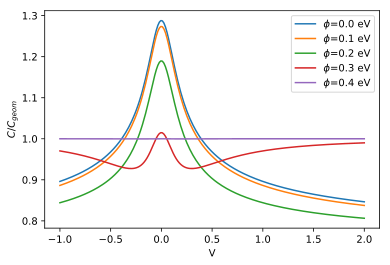

In [5]:
for bar in [0., 0.1, 0.2, 0.3, 0.4]:
    params['electrode0.workfunction'] = -bar
    params['electrode1.workfunction'] = -bar
    cv = np.asarray(list(cvscan(device_model, params, voltages, freq)))
    plt.plot(cv[:, 0], cv[:, 1] / Cgeom, label='$\phi$=%.1f eV' % bar)
plt.legend(loc=0)
plt.xlabel('V')
plt.ylabel('$C/C_{geom}$');

## C-V simulation of asymmetric device, for different values of built-in potential $V_{bi}$

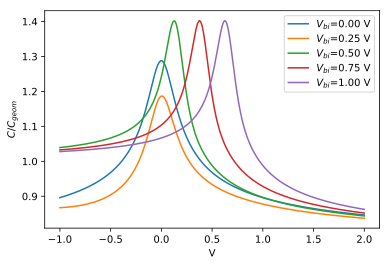

In [6]:
for vbi in [0, 0.25, 0.5, 0.75, 1.]:
    params['electrode0.workfunction'] = 0.
    params['electrode1.workfunction'] = -vbi
    cv = np.asarray(list(cvscan(device_model, params, voltages, freq)))
    plt.plot(cv[:, 0], cv[:, 1] / Cgeom, label='$V_{bi}$=%.2f V' % vbi)
plt.legend(loc=0)
plt.xlabel('V')
plt.ylabel('$C/C_{geom}$');

## C-V simulation of asymmetric device, for fixed built-in voltage 0.5V, and different values of injection barrier $\phi$

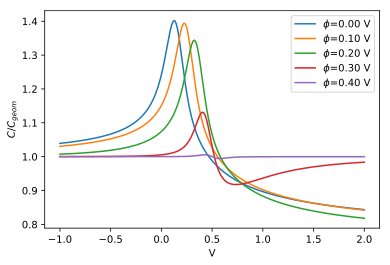

In [7]:
for bar in [0., 0.1, 0.2, 0.3, 0.4]:
    params['electrode0.workfunction'] = -bar
    params['electrode1.workfunction'] = -bar - 0.5
    cv = np.asarray(list(cvscan(device_model, params, voltages, freq)))
    plt.plot(cv[:, 0], cv[:, 1] / Cgeom, label='$\phi$=%.2f V' % bar)
plt.legend(loc=0)
plt.xlabel('V')
plt.ylabel('$C/C_{geom}$');

## C-V simulation of asymmetric device, in function of temperature `T`

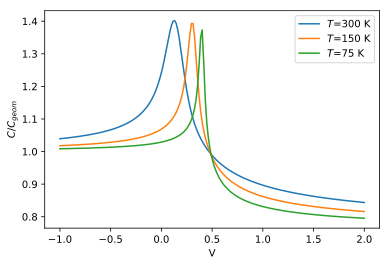

In [8]:
for T in [300., 150., 75.]:
    params['electrode0.workfunction'] = 0.
    params['electrode1.workfunction'] = -0.5
    params['T'] = T
    cv = np.asarray(list(cvscan(device_model, params, voltages, freq)))
    plt.plot(cv[:, 0], cv[:, 1] / Cgeom, label='$T$=%.0f K' % T)
plt.legend(loc=0)
plt.xlabel('V')
plt.ylabel('$C/C_{geom}$');

## Calculation for parameters optimized for experimental data in the reference

In [9]:
params['T'] = 295
params['epsilon_r'] = 3.2
params['electrode0.workfunction'] = -0.015
params['electrode1.workfunction'] = -1.635
params['hole.mu'] = 1e-10
params['hole.N0'] = 1.8e26
Cgeom = params['epsilon_r'] * scipy.constants.epsilon_0 / L

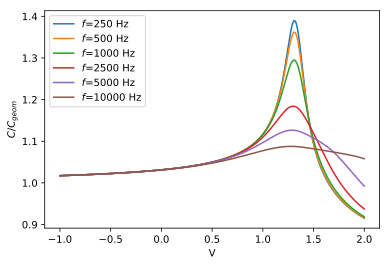

In [10]:
for freq in [250, 500, 1e3, 2.5e3, 5e3, 1e4]:
    cv = np.asarray(list(cvscan(device_model, params, voltages, freq)))
    plt.plot(cv[:, 0], cv[:, 1] / Cgeom, label='$f$=%.0f Hz' % freq)
plt.legend(loc=0)
plt.xlabel('V')
plt.ylabel('$C/C_{geom}$');

### Reference:

S. L. M. van Mensfoort, R. Coehoorn, Determination of Injection Barriers in Organic Semiconductor Devices from Capacitance Measurements, Phys. Rev. Lett. 100, 086802 (2008)


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
